In [167]:
!pip install -q pyannote.audio pyannote.core

import torch
import numpy as np
import os
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
from pyannote.audio.utils.signal import Binarize, Peak
from pyannote.core import Segment, notebook, SlidingWindowFeature, timeline
from IPython.display import clear_output
from scipy.io import wavfile
import scipy.signal as sps
import soundfile as sf
#import librosa


directory48k='C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\Hellos\\input'
directory='C:\\Users\\MrBrito\\Documents\\_Grad_School\\Rotations\\Satra\\egemaps_analysis\\Hellos\\input'

In [171]:
for filename in os.listdir(directory48k):
    # Your new sampling rate
    new_rate = 16000

    # Read file
    sampling_rate, data = wavfile.read(os.path.join(directory48k, filename))

    # Resample data
    number_of_samples = round(len(data) * float(new_rate) / sampling_rate)
    resamp = sps.resample(data, number_of_samples)
    wavfile.write(os.path.join(directory, filename), new_rate, resamp)
    
    #resamp, rate = librosa.load(os.path.join(directory48k, filename), sr=16000)
    

ValueError: File format b'' not understood. Only 'RIFF' and 'RIFX' supported.

In [2]:
# speech activity detection model trained on AMI training set
sad = torch.hub.load('pyannote/pyannote-audio', 'sad_ami')
# speaker change detection model trained on AMI training set
scd = torch.hub.load('pyannote/pyannote-audio', 'scd_ami')
# speaker embedding model trained on AMI training set
emb = torch.hub.load('pyannote/pyannote-audio', 'emb_ami')

Using cache found in C:\Users\MrBrito/.cache\torch\hub\pyannote_pyannote-audio_master
Using cache found in C:\Users\MrBrito/.cache\torch\hub\pyannote_pyannote-audio_master
Using cache found in C:\Users\MrBrito/.cache\torch\hub\pyannote_pyannote-audio_master
C:\Users\MrBrito\miniconda3\lib\site-packages\pyannote\audio\embedding\approaches\arcface_loss.py:170: FutureWarning: The 's' parameter is deprecated in favor of 'scale', and will be removed in a future release
  warnings.warn(msg, FutureWarning)


In [129]:
X, sid_per_sample = [], []
for filename in os.listdir(directory):
    if filename.endswith(".wav"): 
        clear_output(wait=True)
        one_file = {'uri': 'filename', 'audio': os.path.join(directory, filename)}
        
        #detect speaker time versus silence in sample
        sad_scores = sad(one_file)
        binarize = Binarize(offset=0.52, onset=0.52, log_scale=True, min_duration_off=0.1, min_duration_on=0.1)
        speech = binarize.apply(sad_scores, dimension=1)
        
        #extract speaker embeddings and crop only part with speech and remove silence
        embeddings = emb(one_file)
        for segment in speech:
            cropped = embeddings.crop(segment)
        
        X.append(np.mean(cropped, axis=0))

        # keep track of speaker label (for later scatter plot)
        sid_per_sample.append(filename[0:2])
        
        print("Processing" + str(filename))

X = np.vstack(X)
sid, y_true = np.unique(sid_per_sample, return_inverse=True)

Done


C:\Users\MrBrito\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Text(0.5, 1.0, 'tSNE plot of four participants')

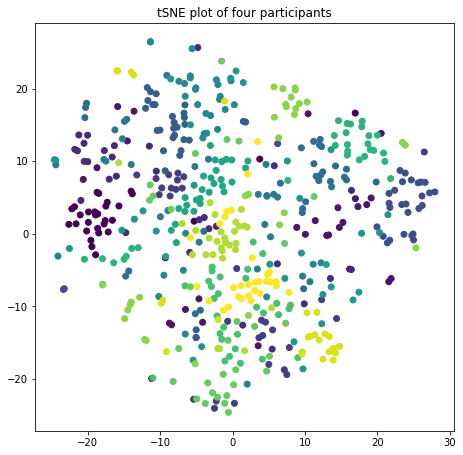

In [139]:
tsne = TSNE(n_components=2, metric="cosine")
X_2d = tsne.fit_transform(X)

# plot 
fig, ax = plt.subplots()
fig.set_figheight(7.5)
fig.set_figwidth(7.5)
#plt.scatter(*X_2d[:120,:].T, c=y_true[:120])
plt.scatter(*X_2d.T, c=y_true)
#plt.legend(y_true[:120], loc='center left', bbox_to_anchor=(1.0, 0.75))
plt.title("tSNE plot of four participants")

Text(0.5, 1.0, 'UMAP plot of four participants')

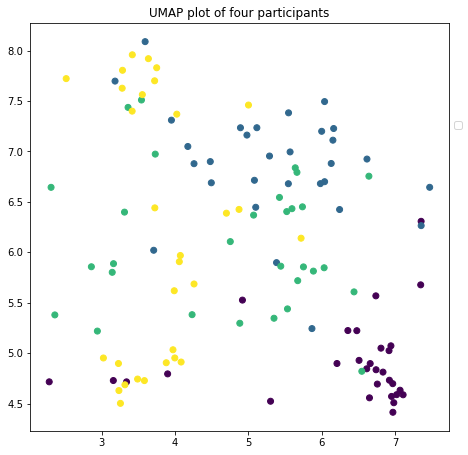

In [138]:
reducer=umap.UMAP()
X_2dU =reducer.fit_transform(X)

# plot 
fig, ax = plt.subplots()
fig.set_figheight(7.5)
fig.set_figwidth(7.5)
plt.legend(y_true[:120], loc='center left', bbox_to_anchor=(1.0, 0.75))
plt.scatter(*X_2dU[:120,:].T, c=y_true[:120])
plt.title("UMAP plot of four participants")